<a href="https://colab.research.google.com/github/MazenMarei25/Machine-Learning-Practice-/blob/main/%20%20%20%20Machine-Learning-Practice-%20%20/Computer%20Vision/Car_parts_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/car-parts-40-classes")

print("Path to dataset files:", path)

100%|██████████| 300M/300M [00:05<00:00, 54.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/car-parts-40-classes/versions/3


In [ ]:
train_dir = "/root/.cache/kagglehub/datasets/gpiosenka/car-parts-40-classes/versions/3/car parts/train"
test_dir = "/root/.cache/kagglehub/datasets/gpiosenka/car-parts-40-classes/versions/3/car parts/test"
valid_dir ="/root/.cache/kagglehub/datasets/gpiosenka/car-parts-40-classes/versions/3/car parts/valid"

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import time

In [ ]:
# Naming the model with a timestamp to save it for later

NAME = "car-parts-cnn-classifier-{}".format(int(time.time()))
log_path = '/content/drive/MyDrive/Colab Notebooks/Practice Code/Deep Learning/CV/logs/{}'.format(NAME)
save_path = '/content/drive/MyDrive/Colab Notebooks/Practice Code/Deep Learning/CV/Saved_models/{}'.format(NAME)
tensorboard = TensorBoard(log_dir=log_path, histogram_freq=1)
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Practice Code/Deep Learning/CV/Saved_models/checkpoint-{epoch:02d}.h5',
    save_weights_only=False,   # saves full model
    save_freq='epoch'          # saves after every epoch
)


Checking the dataset

In [ ]:
# Create from the train,test,val folders the datasets in the format expected by keras
# tf.keras.preprocessing.image_dataset_from_directory() automatically creates an interable of batches of image label pairs

IMAGE_SIZE = (160,160)
BATCH_SIZE = 4

train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="int",batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,shuffle="True",seed=42,color_mode="rgb")

test_ds=tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="int",batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,shuffle="True",seed=42,color_mode="rgb")

valid_ds=tf.keras.preprocessing.image_dataset_from_directory(valid_dir,label_mode="int",batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,shuffle="True",seed=42,color_mode="rgb")

Found 6917 files belonging to 40 classes.
Found 200 files belonging to 40 classes.
Found 200 files belonging to 40 classes.


In [ ]:
# take 1 batch of the image and show its size
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

    # (32, 256, 256, 3) | 32 batches each image is 160x160 and has 3 channels RGB

Images shape: (32, 160, 160, 3)
Labels shape: (32,)


In [ ]:
# print the class names just to make sure
class_names = train_ds.class_names
print(class_names)
print(len(class_names)) # 40 classes

['AIR COMPRESSOR', 'ALTERNATOR', 'BATTERY', 'BRAKE CALIPER', 'BRAKE PAD', 'BRAKE ROTOR', 'CAMSHAFT', 'CARBERATOR', 'COIL SPRING', 'CRANKSHAFT', 'CYLINDER HEAD', 'DISTRIBUTOR', 'ENGINE BLOCK', 'FUEL INJECTOR', 'FUSE BOX', 'GAS CAP', 'HEADLIGHTS', 'IDLER ARM', 'IGNITION COIL', 'LEAF SPRING', 'LOWER CONTROL ARM', 'MUFFLER', 'OIL FILTER', 'OIL PAN', 'OVERFLOW TANK', 'OXYGEN SENSOR', 'PISTON', 'RADIATOR', 'RADIATOR FAN', 'RADIATOR HOSE', 'RIM', 'SPARK PLUG', 'STARTER', 'TAILLIGHTS', 'THERMOSTAT', 'TORQUE CONVERTER', 'TRANSMISSION', 'VACUUM BRAKE BOOSTER', 'VALVE LIFTER', 'WATER PUMP']
40


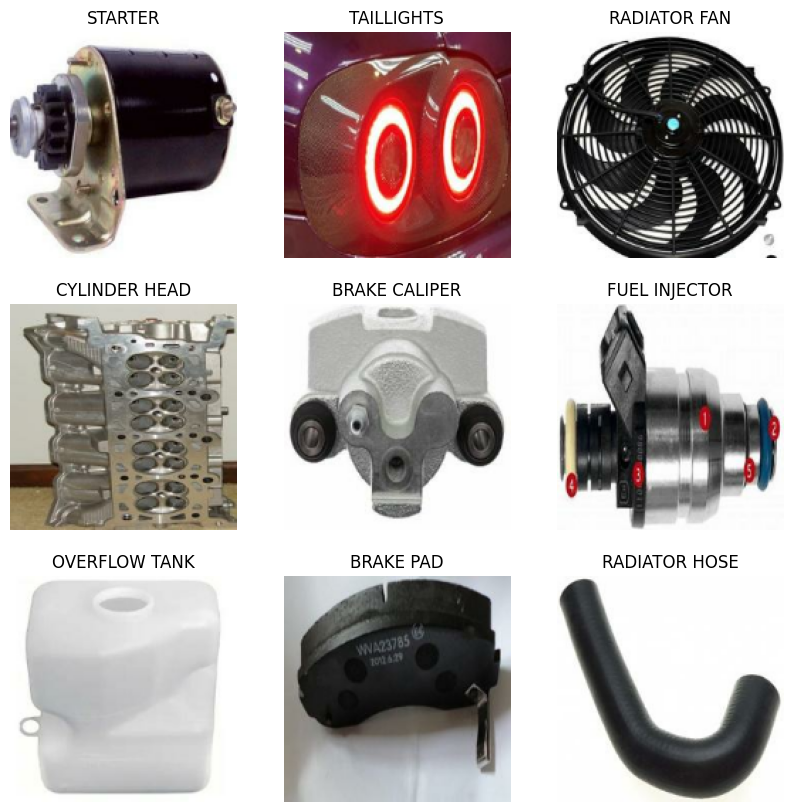

In [ ]:
# visualize the train set
# load a batch from train_ds
# load 9 images and show them sequentially in a 3x3 grid

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [ ]:
#normalize the images
from tensorflow.keras.layers import Rescaling

# We normalize the images in our datasets to lie between [0,1] by using a normalization layer
# This layer divides the inputs by 255
# Note that, sometimes the model (if using a pretrained model) expects [-1,1] so we need to adjust our rescaling factor
# Lambda is a shortened function notation that does the equivalent of :
#
#def normalize_batch(x, y):
#    x_norm = normalization_layer(x)
#    return x_norm, y
# map() applies lambda to every batch in the dataset

normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

Building the Model

In [ ]:
from tensorflow import keras
model = Sequential()
layers = tf.keras.layers
# First conv layer we chose 32 features to detect (arbirary) using a kernel of size(3,3)
# We must pass the image size in the first layer
model.add(layers.Conv2D(32,(3,3), activation= 'relu',input_shape=(160,160,3)))
# Second conv layer we chose 64 features to detect (arbirary) using a kernel of size(3,3)
model.add(layers.Conv2D(64,(3,3), activation= 'relu'))
#Standard pratice maxpool kernel size (2,2)
model.add(MaxPooling2D(2,2))
# Flatten doesnt require inputs, it automatically knows the sizes
model.add(layers.Flatten())
# Standard practice to chose 128 for the dense ANN layer count for medium sized datasets
model.add(layers.Dense(128, activation= 'relu'))
# Final layer must be equal to the number of classes we have, in this code practice we have 40 different car parts
model.add(layers.Dense(40,activation="softmax"))
# Learning rate is a tunable param standard choice of 0.0005, can be tuned using grid search
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 774400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    99,123,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,147,880 (378.22 MB)

 Trainable params: 99,147,880 (378.22 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [ ]:
# Choice of epochs is arbitrary
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds, # Validation set : used to monitor model performance during training while test is used to evaluate the model after it has been trained
  epochs=epochs,
  callbacks=[tensorboard,checkpoint]
)

Epoch 1/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0743 - loss: 6.2441

Saving the model to load it later

In [ ]:
# To reload the model :  model = keras.models.load_model('path/to/location.keras')
# /content/drive/MyDrive/Colab Notebooks/Practice Code/Deep Learning/CV/Saved_models
model.save(save_path)

Loading the Tensorboard graphs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/Practice Code/Deep Learning/CV/logs"

Testing our model

In [ ]:
# Get predictions on test dataset
predictions = model.predict(test_ds)

# Convert probabilities to class indices
pred_classes = np.argmax(predictions, axis=1)

# Get class names
class_names = test_ds.class_names

# Grab a single batch from test_ds
for images, labels in test_ds.take(1):
    images = images.numpy()      # Convert tensor to numpy
    labels = labels.numpy()      # True labels

# Display first 9 images in a grid
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype("uint8"))
    true_label = class_names[labels[i]]
    pred_label = class_names[pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis("off")
plt.show()


In [ ]:
metrics = model.evaluate(test_ds)
print("Test Loss:", metrics[0])
print("Test Accuracy:", metrics[1])